In [1]:
import torch
import lmdb
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as log_progress
from collections import OrderedDict

from torch.utils.data import Dataset, DataLoader
from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.models.image_restoration_model import ImageRestorationModel
from basicsr.utils.options import parse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.metrics import structural_similarity as ssim

mse = torch.nn.MSELoss()
ssim = ssim

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
finetuned_weight_path = '/home/gridsan/tye/NAFNet/experiments/FMD-SHG-08-29/models/net_g_20000.pth'
#Substitute in for final github repo
#fintuned_weight_path = "./Experiments/finetuned_weights.pth"
finetuned_model_weights = torch.load(finetuned_weight_path)

opt = parse('./base_NAF/NAFNet-width64.yml', is_train=False)
opt['dist'] = False

finetuned = create_model(opt)
finetuned = finetuned.net_g
finetuned.load_state_dict(finetuned_model_weights['params'])
print('finetuned weights loaded successfully')

2023-10-29 23:39:36,948 INFO: Model [ImageRestorationModel] is created.


finetuned weights loaded successfully


In [4]:
a = './Visualization/2:1_1_1_1_1_NOISY.pt'
b = './Visualization/2:1_2_1_1_1_NOISY.pt'
c = './Visualization/2:1_2_3_1_1_NOISY.pt'
d = './Visualization/2:1_2_3_4_1_NOISY.pt'
e = './Visualization/2:1_2_3_4_5_NOISY.pt'
gt_path = './Visualization/2:1_1_1_1_1_GT.pt'
imgs = [a, b, c, d, e, gt_path]

In [5]:
uncertainties = []
predictions = []

with torch.no_grad():
    for i in log_progress(range(0, 5)):
        noisy = torch.load(imgs[i])
        in_img = noisy.unsqueeze(0).to(device).float()
        
        out = finetuned(in_img).detach().cpu().numpy()    
        
        uncertainty = (out[0, 2, :, :] - out[0, 0, :, :])
        img = out[0, 1, :, :]
        img = img/np.max(img)

        uncertainties.append(uncertainty)
        predictions.append(img)

Evaluating Denoised and Uncertainty Results:
As discussed in the paper (Sections 5.1, 5.2), increasing the number of nosiy sample inputs to the model will increase the accuracy of the denoised images. Additionally, as the number of noisy image inputs increase, the uncertainty prediction of each output will start decreasing. 

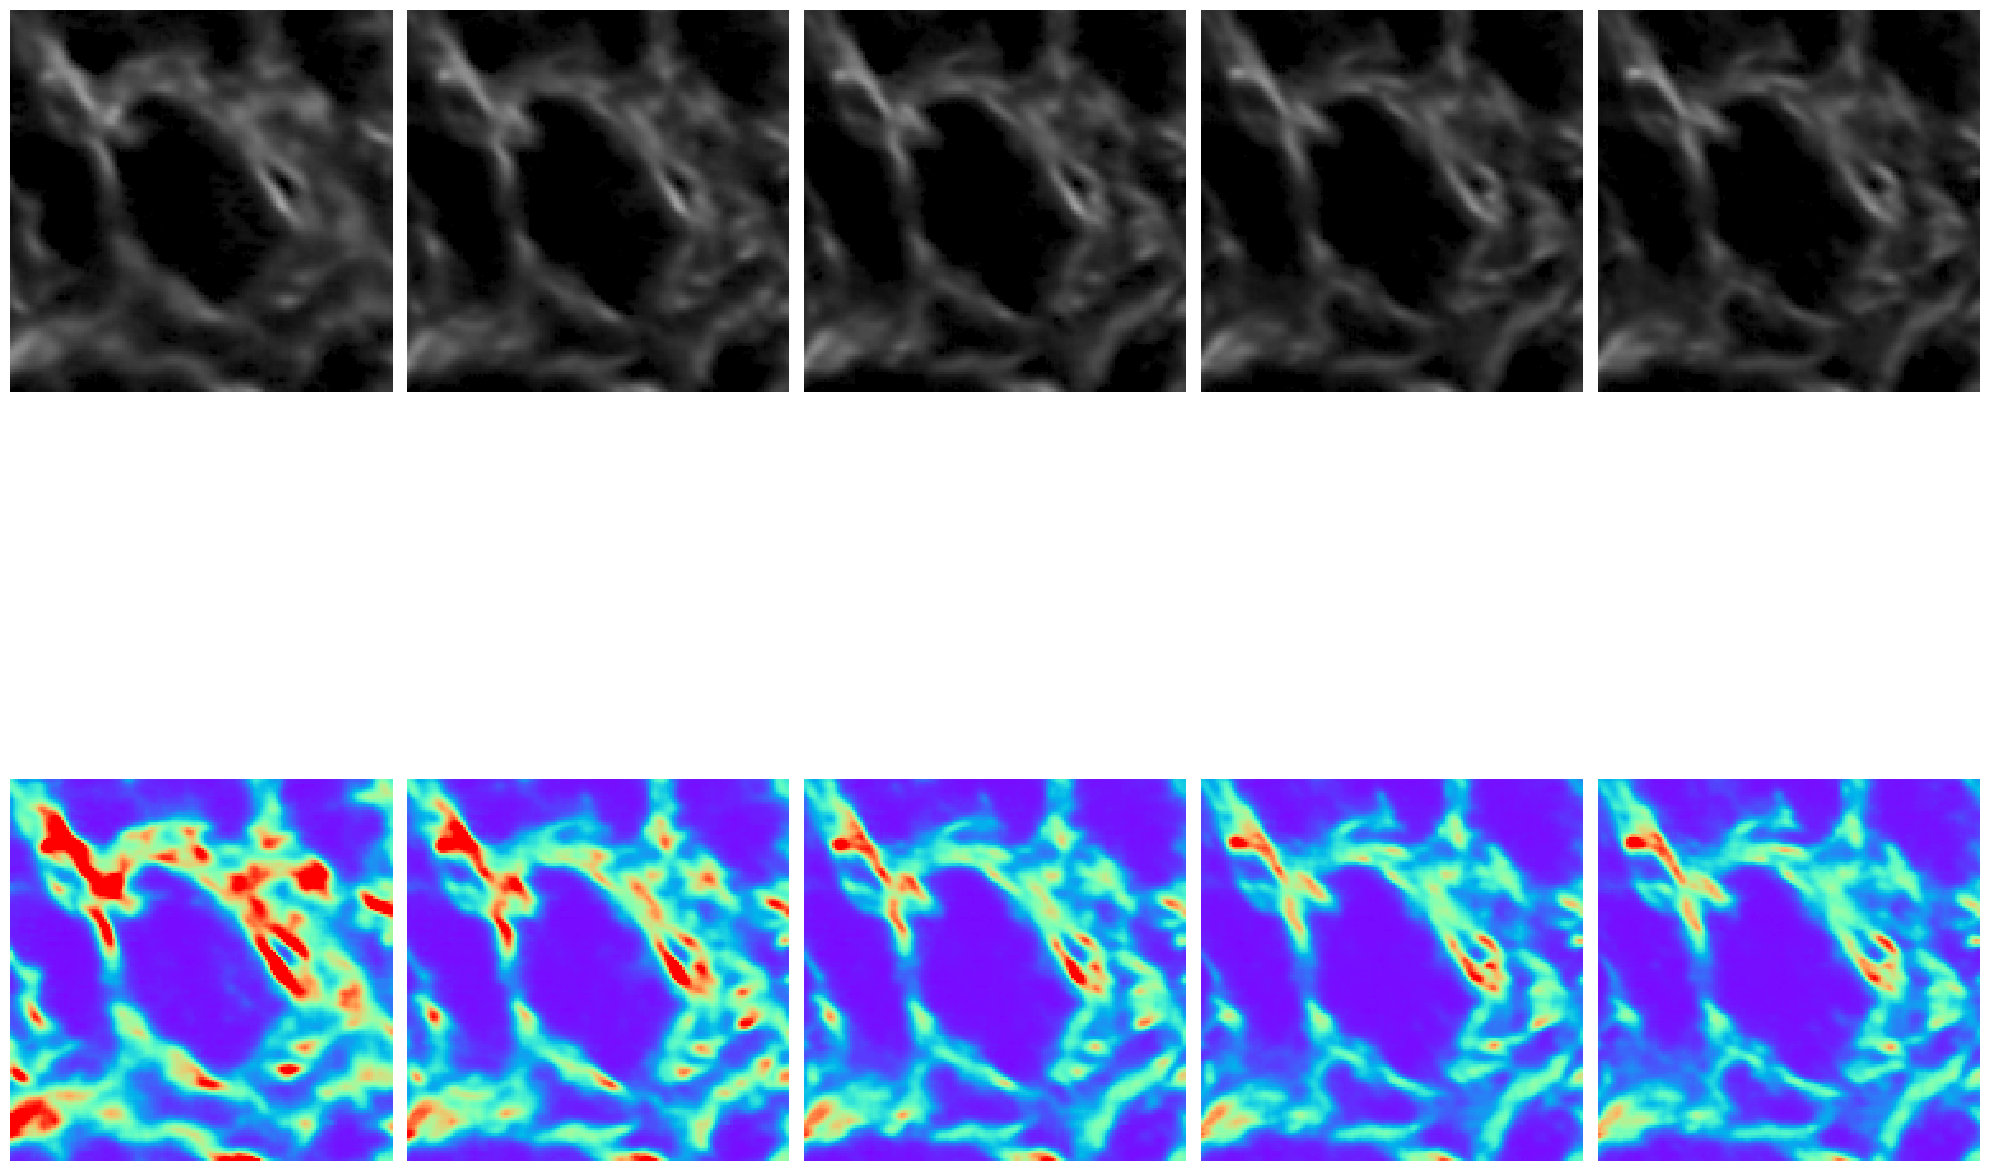

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(20, 20))  
plt.subplots_adjust(wspace=0.1, hspace=0.1)

x = 75
y = 325
images = predictions
for ax, image in zip(axes[0], images):
    img = np.clip(image, 0,1)
    im = ax.imshow(img[x:x + 150, y: y + 150] ** (1/2.2), cmap='gray', vmin=0, vmax=1)  
    ax.axis('off')

images = uncertainties
vmin, vmax = 0, np.percentile(images[0], 95)
for ax, image in zip(axes[1], images):
    img = np.clip(image, 0, vmax)
    im = ax.imshow(img[x:x + 150, y: y + 150], cmap='rainbow', vmin=vmin, vmax=vmax)  
    ax.axis('off')

plt.tight_layout()  
plt.show()

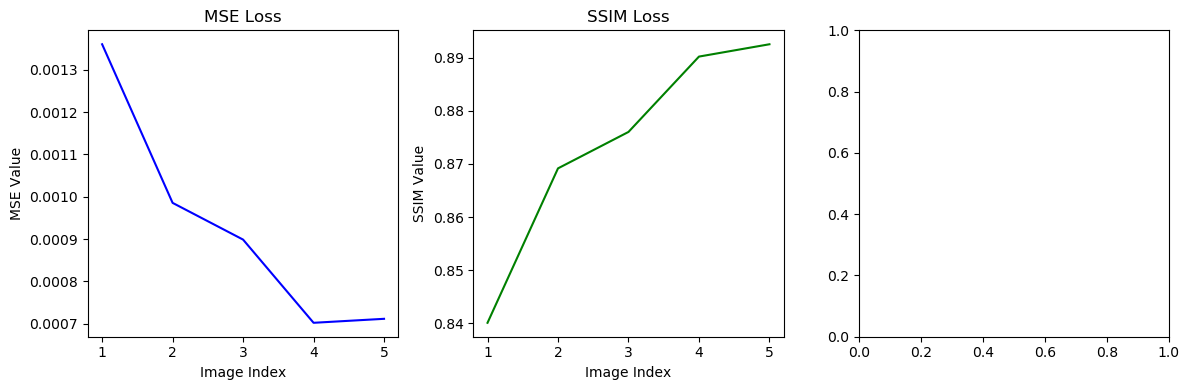

In [7]:
gt = torch.load(gt_path)
gt_img = gt[0, :, :]
gt_img = torch.clip(gt_img/torch.max(gt_img), 0, 1)

mse_loss = []
ssim_loss = []

for im in predictions:
    mse_loss.append(mse(torch.tensor(im), gt_img).item())
    ssim_loss.append(ssim(im.astype(np.float64), gt_img.numpy()))

# Plot MSE loss
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].plot(torch.linspace(1, 5, 5), mse_loss, label='MSE Loss', color='blue')
axes[0].set_title('MSE Loss')
axes[0].set_xlabel('Image Index')
axes[0].set_ylabel('MSE Value')

# Plot SSIM loss
axes[1].plot(torch.linspace(1, 5, 5), ssim_loss, label='SSIM Loss', color='green')
axes[1].set_title('SSIM Loss')
axes[1].set_xlabel('Image Index')
axes[1].set_ylabel('SSIM Value')

plt.tight_layout()
plt.show()

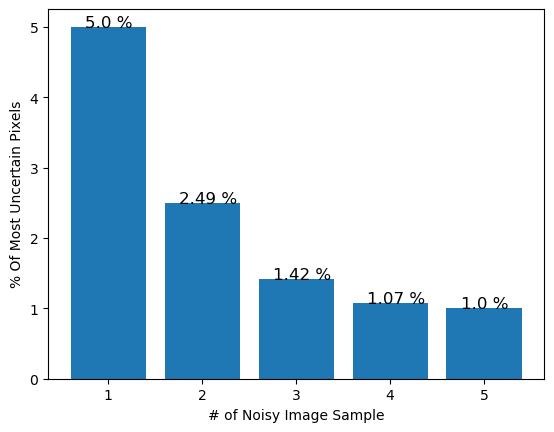

In [8]:
vmin, vmax = 0, np.percentile(images[0], 95)
counts = []

for i in range(len(uncertainties)):
    im = images[i]
    count = 0
    for x in range(len(im)):
        for y in range(len(im)):
            if im[x][y] >= vmax:
                count += 1
    counts.append(np.round(count/(512**2) * 100, 2))

plt.bar(torch.linspace(1,5, 5), counts)
for index,data in enumerate(counts):
    plt.text(x=index + 0.75 , y =data , s=f"{data} %" , fontdict=dict(fontsize=12))
plt.xlabel("# of Noisy Image Sample")
plt.ylabel("% Of Most Uncertain Pixels")
plt.show()   

vmax =  0.11265234686434268
(512, 512)
(512, 512)
(512, 512)
(512, 512)


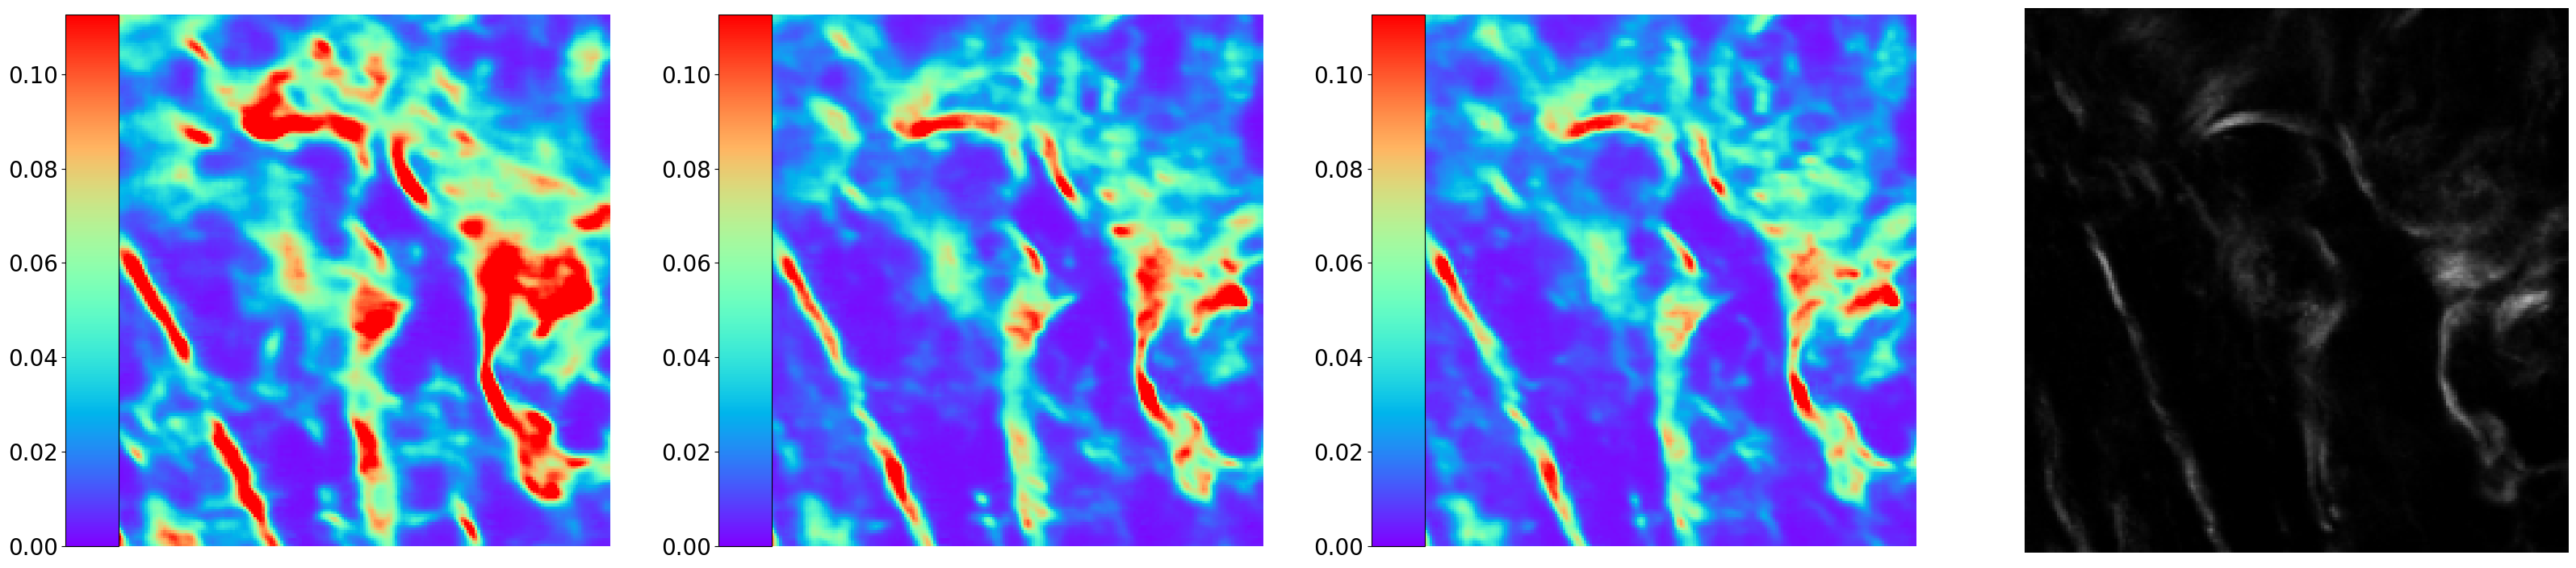

In [9]:
gt = torch.load(gt_path)
gt_img = torch.mean(gt, 0)
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(1, 4, figsize=(40, 10))  # Adjust figsize as needed

images = [uncertainties[0], uncertainties[2], uncertainties[4], gt_img]
vmin = 0
vmax =  np.percentile(images[0], 95)
print('vmax = ', vmax)
print(images[0].shape)

count = 0
for ax, image in zip(axes, images):
    divider = make_axes_locatable(ax)
    img = image


    if count == 3:
        im = ax.imshow(gt_img[50:250, 50:250], cmap='gray', vmin = 0, vmax = 0.5)  
        ax.axis('off')
        
    else:
        img = np.clip(img, 0, vmax)
        print(img.shape)
        im = ax.imshow(img[50:250, 50:250], cmap='rainbow', vmin=vmin, vmax=vmax)  
        cax = divider.append_axes('left', size='10%', pad= -0.5)
        colorbar = plt.colorbar(im, cax=cax, orientation='vertical')
        cax.yaxis.set_ticks_position('left')
        cax.tick_params(labelsize=20, direction = 'out') 
        ax.axis('off')
    count += 1
    
plt.show()